#### Step
1. calculating hyper and hypo regulation
2. filter genes by dbeta values
3. filter genes by hyper/hypo regulation and TSS position
4. plot distribution of dbeta values
5. plot PCA for normal and tumor
* if you see example annotation, please replace it by your need

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

#### 計算Hyper/Hypo

In [120]:
cancer = "breast" # example
input_file_path = "result/GSE89093_nc/train100" # example
input_path = f"../{cancer}/{input_file_path}/dbeta.csv"
dbeta = pd.read_csv(input_path)
dbeta

,ID,gene,dbeta,feature
0,cg16531903,A1CF,0.013321,TSS1500
1,cg27166707,A2M,-0.006354,Body
2,cg24309769,A2ML1,-0.074597,Body
3,cg13001012,AADAC,0.007991,TSS1500
4,cg25628542,AADAT,0.034433,Body
...,...,...,...,...
8119,cg06155771,ZNRD1,0.013769,Body
8120,cg16483867,ZNRF3,-0.013046,Body
8121,cg22721334,ZSCAN18,-0.013064,1stExon
8122,cg16899823,ZWINT,-0.021684,TSS200


In [121]:
beta_normalized_train = pd.read_csv(f"../{cancer}/champ_result/GSE89093/all_beta_normalized.csv") # example

df_gene = beta_normalized_train[
    beta_normalized_train[beta_normalized_train.columns[0]].isin(dbeta["ID"])
]
df_gene.reset_index(drop=True, inplace=True)
print(df_gene.shape)
df_gene.head()

(8124, 93)


,ID_REF,0,1,2,3,4,5,6,7,8,...,82,83,84,85,86,87,88,89,90,91
0,cg00000029,0.486644,0.472790,0.440157,0.401009,0.403449,0.453738,0.505430,0.525945,0.539579,...,0.586559,0.557733,0.515352,0.570047,0.586289,0.428182,0.410767,0.535594,0.561125,0.534982
1,cg00000236,0.798909,0.720664,0.745585,0.751120,0.738786,0.777767,0.776491,0.839313,0.830973,...,0.795153,0.799779,0.796590,0.831788,0.794952,0.783985,0.720944,0.756649,0.848983,0.820339
2,cg00001349,0.855791,0.829152,0.825407,0.904369,0.811729,0.840144,0.854327,0.859187,0.861867,...,0.754354,0.866894,0.854481,0.851249,0.799986,0.689728,0.765771,0.722719,0.823307,0.784522
3,cg00004818,0.067996,0.048619,0.052120,0.020734,0.028761,0.054896,0.009297,0.020890,0.024706,...,0.040391,0.030287,0.063124,0.092532,0.048471,0.061991,0.077810,0.042835,0.040646,0.069941
4,cg00007076,0.439531,0.462521,0.454838,0.468549,0.469484,0.484968,0.466161,0.475500,0.478567,...,0.515847,0.515664,0.510615,0.472859,0.450258,0.364809,0.461599,0.416490,0.351730,0.551100


In [122]:
# if data has been splitted into train and test set, you can use this code
# label = beta_normalized_train[
#     beta_normalized_train[beta_normalized_train.columns[0]] == "label"
# ]
# normal_columns = label.columns[(label.iloc[0] == 0.0)].tolist()
# tumor_columns = label.columns[(label.iloc[0] == 1.0)].tolist()
# train_normal = df_gene[normal_columns]
# train_tumor = df_gene[tumor_columns]

# if normal and tumor label are continuous
normal_count = 46 # example
train_normal = df_gene.iloc[:, 1 : normal_count + 1] # if your data is duplicate, please filter by yuorself
train_tumor = df_gene.iloc[:, normal_count + 1 :]  # if your data is duplicate, please filter by yuorself

print(train_tumor.shape)
print(train_normal.shape)

(8124, 46)
(8124, 46)


In [123]:
train_normal_avg = train_normal.mean(skipna=True, axis=1)
print(train_normal_avg.shape)
tt_dbeta = (train_tumor).subtract(train_normal_avg, axis=0)
avg_tumordBeta = tt_dbeta.mean(axis=1)
print(avg_tumordBeta.shape)

(8124,)
(8124,)


In [124]:
methylation_level_df = pd.DataFrame(
    {
        "ID": df_gene[df_gene.columns[0]],
        "methylation_level": avg_tumordBeta.apply(
            lambda x: "Hyper" if x > 0 else "Hypo"
        ),
    }
)
result = pd.merge(dbeta, methylation_level_df, on="ID", how="inner")
result

,ID,gene,dbeta,feature,methylation_level
0,cg16531903,A1CF,0.013321,TSS1500,Hyper
1,cg27166707,A2M,-0.006354,Body,Hypo
2,cg24309769,A2ML1,-0.074597,Body,Hyper
3,cg13001012,AADAC,0.007991,TSS1500,Hypo
4,cg25628542,AADAT,0.034433,Body,Hyper
...,...,...,...,...,...
8119,cg06155771,ZNRD1,0.013769,Body,Hyper
8120,cg16483867,ZNRF3,-0.013046,Body,Hypo
8121,cg22721334,ZSCAN18,-0.013064,1stExon,Hyper
8122,cg16899823,ZWINT,-0.021684,TSS200,Hypo


#### 過濾dbeta門檻值

In [125]:
def set_threshold(data, threshold, save_path):
    data = data[abs(data["dbeta"]) > threshold]
    data.to_csv(save_path, index=False)
    return data

threshold = 0.02  # example threshold
save_path = f"../{cancer}/{input_file_path}/dbeta_{threshold}.csv"
filter_dbeta = set_threshold(result, threshold, save_path)

#### 過濾Hyper/TSS

In [126]:
# if you want filter by Hyper/Hypo
result_hyper = filter_dbeta[filter_dbeta["methylation_level"] == "Hyper"]
result_hyper.to_csv(
    f"../{cancer}/{input_file_path}/dbeta_hyper_{threshold}.csv", index=False
)

# if you want filter by TSS
result_hyper_TSS = result_hyper[result_hyper["feature"].str.contains("TSS")]
result_hyper_TSS.to_csv(
    f"../{cancer}/{input_file_path}/dbeta_hyper_TSS_{threshold}.csv", index=False
)
result_hyper_TSS

,ID,gene,dbeta,feature,methylation_level
83,cg10607155,ACTG1,-0.023059,TSS1500,Hyper
176,cg00432461,ADRB3,0.032629,TSS1500,Hyper
264,cg25251562,ALLC,0.051469,TSS1500,Hyper
371,cg09558982,APOA1,0.033464,TSS200,Hyper
453,cg12912293,ARNT,0.020066,TSS1500,Hyper
...,...,...,...,...,...
7467,cg24483493,TPM1,0.021176,TSS1500,Hyper
7823,cg02371408,VCAN,-0.021545,TSS1500,Hyper
7851,cg10998286,VPS11,-0.021512,TSS1500,Hyper
8013,cg26021304,ZFP57,0.042011,TSS200,Hyper


#### 查看dbeta分布

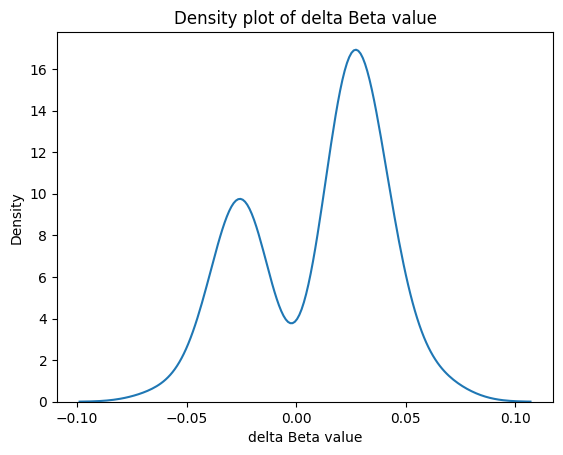

In [127]:
def get_distribution(data):
    sns.kdeplot(data["dbeta"])
    plt.xlabel("delta Beta value")
    plt.title("Density plot of delta Beta value")


get_distribution(result_hyper_TSS)  # example data

#### 查看normal/tumor分布

In [128]:
X = pd.concat([train_normal, train_tumor], axis=1).T
normal_count = 46  # example normal count
y = [(0 if i < normal_count else 1) for i in range(X.shape[0])]
print(X.shape)
print(len(y))

(92, 8124)
92


In [129]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)


def plot_pca_3d(elev, azim):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap="viridis")
    legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend1)
    ax.set_title("PCA of Iris Dataset")
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_zlabel("Principal Component 3")

    ax.view_init(elev=elev, azim=azim)
    plt.show()


interact(
    plot_pca_3d,
    elev=widgets.FloatSlider(min=0, max=360, step=1, value=30),
    azim=widgets.FloatSlider(min=0, max=360, step=1, value=120),
)

interactive(children=(FloatSlider(value=30.0, description='elev', max=360.0, step=1.0), FloatSlider(value=120.…

<function __main__.plot_pca_3d(elev, azim)>